<br>
<br>
<center>
    
# 人工智能高阶人才培训班

<br>

> ## 如何用 DNN 实现猫狗识别
</center>
<br>

<img src='../static/img/logo.jpg' align='right' style="width:260px;height:60px;display:block"/>

# 猫🐱-狗🐕分类问题


![](img/cat-dog.jpeg)

> 背景：Kaggle比赛，25，000张训练图像,通过使用深度学习算法，kaggle上目前取得了98%的准确率，我们仅使用8%的数据集，一起来看下效果

前面在如何构建一个人工智能项目的实验中，我们已经学习了人工智能项目的构建流程，并且实现了基于迁移学习的猫狗识别系统。在本次实验中，我们将从头开始训练一个DNN的猫狗识别系统。

在本次实验中，我们将遵循人工智能项目的构建流程，按照如下步骤完成实验：
0. 定义问题
1. 了解数据
2. 构建数据工作的pipeline

3. 构建模型

4. 训练模型
5. 评估模型

In [1]:
import os
import random

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  2.0.0


## 0. 问题定义

> 猫狗分类实质上是一个二分类问题，输入的是图像数据，输出的是分类的结果

## 1. 数据导入及数据理解

### 下载并获取数据 - cats_and_dogs_filtered.zip
Kaggle 中原始数据可以通过链接 [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) 获取。本实验只使用其一个子集。

In [2]:
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                   fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)

In [3]:
base_dir

'/home/iniesa/.keras/datasets/cats_and_dogs_filtered'

### 准备训练数据和验证数据


In [4]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


> 训练样本很平衡

### 创建数据生成器
* 读取数据文件
* jpg文件--> rgb array--> tensor
* 将0-255的像素值缩放到[0, 1]之间；试试标准化？
* 图片大小统一到(64,64);为什么图片不是（160,160）了？
* 数据增强

In [5]:
image_size = 64 # All images will be resized to 64x64
batch_size = 256

In [6]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
         train_dir,  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 随机查看一组数据

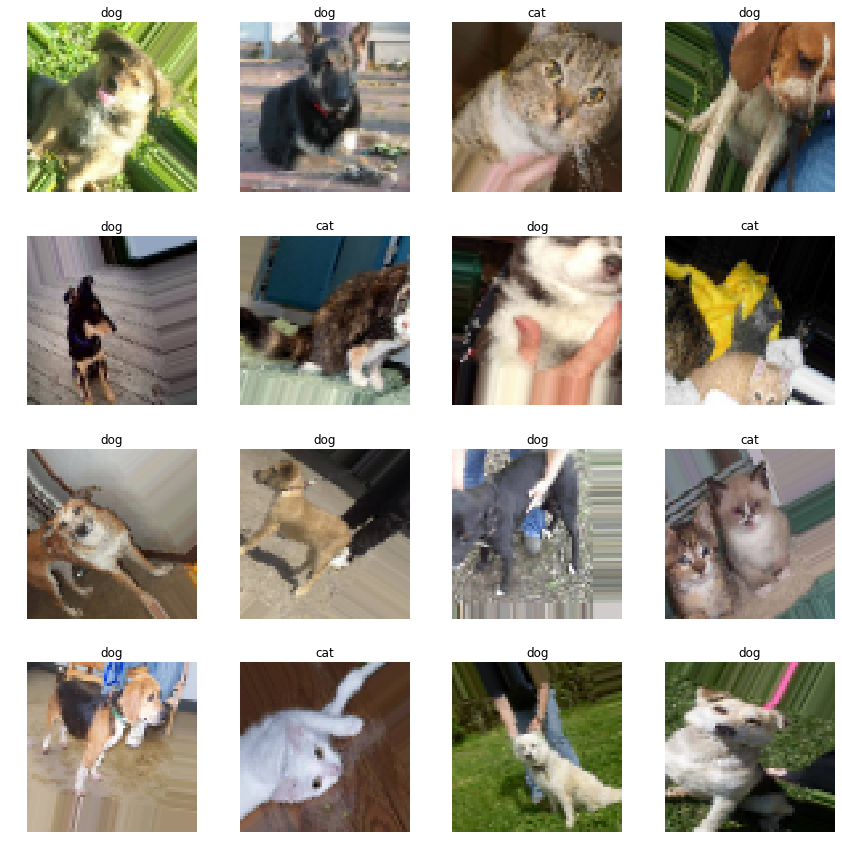

In [7]:
plt.figure(figsize=(12,12))

for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.axis('off')
        plt.imshow(image)
        label = "dog" if Y_batch[0]==1 else "cat" 
        plt.title(label)
        break
plt.tight_layout()
plt.show()

## 使用DNN模型构建解决该问题的基准模型

在本节中，我们将构建并训练DNN网络。



### 构建模型

In [11]:
IMAGE_SHAPE = (image_size, image_size, 3)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten

model = Sequential(name='DNN_CAT_DOG')
## 将tensor 展开
model.add(Flatten(input_shape=IMAGE_SHAPE))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))

model.add(Dense(256,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "DNN_CAT_DOG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1572992   
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                

### 编译模型
在模型训练之前，通过编译，告诉模型优化目标和优化方法

> 特别注意学习率

In [12]:

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 模型训练

训练10个迭代，我们就已经取得了~94%的准确率；

如果你可以使用更多的训练迭代，预计可以收敛更好的准确率(比如尝试使用50轮迭代， ~96%)

In [13]:
#epochs = 10
epochs = 100
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/100
7/7 [==============================] - 3s 406ms/step - loss: 0.7004 - accuracy: 0.4971 - val_loss: 0.7001 - val_accuracy: 0.5052
Epoch 2/100
7/7 [==============================] - 3s 412ms/step - loss: 0.7007 - accuracy: 0.4868 - val_loss: 0.7010 - val_accuracy: 0.4948
Epoch 3/100
7/7 [==============================] - 3s 399ms/step - loss: 0.6954 - accuracy: 0.5011 - val_loss: 0.6957 - val_accuracy: 0.4948
Epoch 4/100
7/7 [==============================] - 3s 360ms/step - loss: 0.6973 - accuracy: 0.5147 - val_loss: 0.6911 - val_accuracy: 0.5521
Epoch 5/100
7/7 [==============================] - 3s 358ms/step - loss: 0.6903 - accuracy: 0.5352 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 6/100
7/7 [==============================] - 2s 332ms/step - loss: 0.6925 - accuracy: 0.5166 - val_loss: 0.6932 - val_accuracy: 0.4948
Epoch 7/100
7/7 [==============================] - 3s 367ms/step - loss: 0.6918 - accuracy: 0.5304 - val_loss: 0.6884 - val_accuracy: 0.5286
Epoch 8/100
7

Epoch 59/100
7/7 [==============================] - 3s 391ms/step - loss: 0.6731 - accuracy: 0.5820 - val_loss: 0.6582 - val_accuracy: 0.5964
Epoch 60/100
7/7 [==============================] - 2s 354ms/step - loss: 0.6668 - accuracy: 0.5938 - val_loss: 0.6585 - val_accuracy: 0.6055
Epoch 61/100
7/7 [==============================] - 2s 334ms/step - loss: 0.6572 - accuracy: 0.6061 - val_loss: 0.6619 - val_accuracy: 0.6016
Epoch 62/100
7/7 [==============================] - 2s 348ms/step - loss: 0.6666 - accuracy: 0.5900 - val_loss: 0.6631 - val_accuracy: 0.5964
Epoch 63/100
7/7 [==============================] - 2s 351ms/step - loss: 0.6554 - accuracy: 0.6177 - val_loss: 0.6577 - val_accuracy: 0.5859
Epoch 64/100
7/7 [==============================] - 1s 207ms/step - loss: 0.6723 - accuracy: 0.6061 - val_loss: 0.6589 - val_accuracy: 0.5990
Epoch 65/100
7/7 [==============================] - 2s 293ms/step - loss: 0.6644 - accuracy: 0.5981 - val_loss: 0.7144 - val_accuracy: 0.5312
Epoch 

### 结果分析

我们可以通过训练集/验证集的准确率及损失情况来评估训练结果的好坏

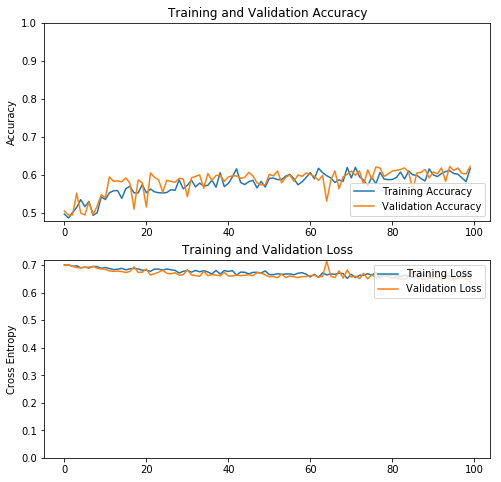

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

### 保存模型

In [15]:
model.save("base_mode.h5")

### 在测试图像上应用模型

In [16]:
class_names = {1:'狗', 0:'猫'}  

In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [18]:
test_f = load_img("test/dog.jpg", target_size=(image_size, image_size))
test_f = img_to_array(test_f)
test_f = np.expand_dims(test_f,axis=0)
test_f = test_f / 225.

In [19]:
pred = model.predict(test_f)
print(pred)

[[0.5940255]]


In [20]:
result = class_names[0] if pred[0]<0.5 else class_names[1] 
print("预测结果是： %s" %result)

预测结果是： 狗


### 思考：为什么效果这么不好？